# Figure 7

In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib as mpl
import scipy.stats as stats

from scipy.optimize import curve_fit
import pickle


# Import code
sys.path.insert(0, './../../../Scripts/scripts_unstructured/')
import functions as fun



# Load data

In [3]:

folder_data='./../../DataAndScripts/experimental_data/'
data_monkeys=np.loadtxt(folder_data+'Monkeys_with_trials.txt');
data_mice=np.loadtxt(folder_data+'Mice_with_trials.txt');


DATA=[data_mice,data_monkeys]
species=['Mice','Monkeys']
color=['c','m']
bin_edges=np.arange(-300,300,0.1) 
bin_means=(bin_edges[1::]+bin_edges[0:-1])/2   



# Load model sims

In [6]:
folder_sims='./generate_simulations/'


model_unstructured_mice=np.load(folder_sims+'RATES_unstructured_mouse.npy')
model_unstructured_monkeys=np.load(folder_sims+'RATES_unstructured_monkey.npy')


MODEL=[model_unstructured_mice,model_unstructured_monkeys]

# Load normalization fits

In [8]:
fits=pickle.load(open('./generate_normalization_fits/RsqDoS_Simple_together.pkl', 'rb'));


#  Plot

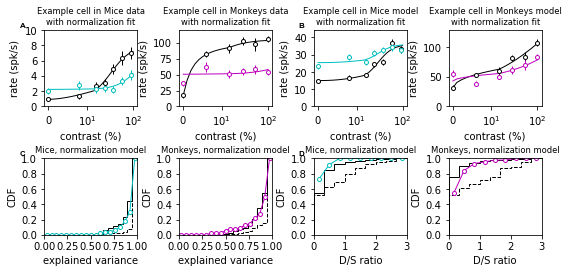

In [10]:
rows=2;cols=4;

fig, axs = plt.subplots(rows,cols, figsize=(2.5*cols,2.*rows), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)
area=4.0;linethicknes=1.0;
axs = axs.ravel()

DeltaT=0.1
Ntrial=[100,20]

font = {'family' : 'normal','weight' : 'normal','size'   : 7, 'family':'serif','serif':['Arial']}
mpl.rc('font', **font)
mpl.rcParams['lines.linewidth'] =linethicknes
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['pdf.fonttype'] = 42


axs[0].text(-.2, 1.1,'A', transform=axs[0].transAxes,fontsize=8, fontweight='bold', va='top', ha='right');
axs[2].text(-.1, 1.1,'B', transform=axs[2].transAxes,fontsize=8, fontweight='bold', va='top', ha='right');
axs[4].text(-.2, 1.1,'C', transform=axs[4].transAxes,fontsize=8, fontweight='bold', va='top', ha='right');
axs[6].text(-.1, 1.1,'D', transform=axs[6].transAxes,fontsize=8, fontweight='bold', va='top', ha='right');


idx_laser=-1
ConCon=np.linspace(0,100,100)
for idx_species in [0,1]:
    data=DATA[idx_species]
    model=MODEL[idx_species]
    Con=np.unique(data[:,1])
    Las=np.unique(data[:,2])
    cells_id=np.unique(data[:,0]);

    Las=[Las[0],Las[-1]]
    ##################################################
    ## Example cells data
    ##################################################
    xmax=[50,250][idx_species]
    c=['k',color[idx_species]]
    Mod=['N','E','S']


    Cell=[];Contrast=[];Base=[];Resp=[];eBase=[];eResp=[];

    for idx_cell in range(len(cells_id)):
        for idx_con in range(len(Con)):
            mask_no_L=(data[:,0]==cells_id[idx_cell])&(data[:,2]==Las[0])&(data[:,1]==Con[idx_con])
            mask_L=(data[:,0]==cells_id[idx_cell])&(data[:,2]==Las[idx_laser])&(data[:,1]==Con[idx_con])
            Cell=Cell+[idx_cell]
            Contrast=Contrast+[data[mask_L,1]]
            Trial_Base=data[mask_no_L,3::]
            Trial_Resp=data[mask_L,3::]
            Base=Base+[np.mean(Trial_Base[np.isnan(Trial_Base)==False])]
            Resp=Resp+[np.mean(Trial_Resp[np.isnan(Trial_Resp)==False])]
            eBase=eBase+[stats.sem(Trial_Base[np.isnan(Trial_Base)==False])]
            eResp=eResp+[stats.sem(Trial_Resp[np.isnan(Trial_Resp)==False])]

    Cell,Contrast,Base,Resp=np.asarray(Cell),np.asarray(Contrast),np.asarray(Base),np.asarray(Resp)
    eBase,eResp=np.asarray(eBase),np.asarray(eResp)

    if idx_species==0:
        ymax=[25,15,10]
        example_cells=[25,45,49]
    if idx_species==1:
        ymax=[175,60,120]
        example_cells=[0,21,54]
        
    for idx_case in [2]: 
        mask=Cell==example_cells[idx_case]
        for idx_las in [0,1]:
            m=[Base[mask],Resp[mask]][idx_las]
            e=[eBase[mask],eResp[mask]][idx_las]
            axs[0+idx_species].errorbar(Con, m,e,c=c[idx_las],
                                      marker='o',linestyle='', ms=4,  mfc='w',
                                      label=['without opto','with opto'][idx_las])

            if idx_las==0:
                def func(c,Rm,Ro,n,sigma):
                    pippo=(Ro+Rm*sigma*c**n)/(1+sigma*c**n)
                    return (pippo+np.abs(pippo))/2
                popt_contrast, pcov = curve_fit(func, Con, m,bounds=(0, np.inf),
                                            p0=np.asarray([m[0],m[-1],1,1]))
                axs[0+idx_species].plot(ConCon,func(ConCon, *popt_contrast),c=c[idx_las])

            if idx_las==1:
                def func_L(c,D,S):
                    Rm,Ro,n,sigma=popt_contrast[:]
                    pippo=(Ro+Rm*sigma*c**n+D)/(1+sigma*c**n+S)
                    return (pippo+np.abs(pippo))/2
                [D,S], pcov = curve_fit(func_L, Con, m,bounds=(0, np.inf))
                axs[0+idx_species].plot(ConCon,func_L(ConCon, D,S),c=c[idx_las])


        axs[0+idx_species].set_xscale('symlog', linthresh=12);
        axs[0+idx_species].set_ylim([0,ymax[idx_case]]);

    
        axs[0+idx_species].set_ylabel('rate (spk/s)')
        axs[0+idx_species].set_xlabel('contrast (%)')
    
    

        
        
axs[0].set_title('Example cell in Mice data\nwith normalization fit');
axs[1].set_title('Example cell in Monkeys data\nwith normalization fit');

idx_las=-1

for idx_species in [0,1]:
    data=DATA[idx_species]
    model=MODEL[idx_species]
    Con=np.unique(data[:,1])
    Las=np.unique(data[:,2])
    cells_id=np.arange(1000)#np.unique(data[:,0]);

    Las=[Las[0],Las[-1]]
    ##################################################
    ## Example cells model
    ##################################################
    xmax=[50,250][idx_species]
    c=['k',color[idx_species]]
    Mod=['N','E','S']
    idx_las=-1


    

        
    if idx_species==0:
        ymax=[25,15,10]
    if idx_species==1:
        ymax=[175,60,120]
        
    for idx_case in [2]: 
        if (idx_species==0)&(idx_case==2):
            #idx_cell=np.where((Cell_Mod[:,0]==1)&(Cell_Mod[:,1]==-1))[0][2]
            idx_cell=np.where(((model[0,-1,:]-model[0,0,:])>5)&((model[-1,-1,:]-model[-1,0,:])<-5))[0][5]
        if (idx_species==1)&(idx_case==2):
            #idx_cell=np.where((Cell_Mod[:,0]==1)&(Cell_Mod[:,1]==-1))[0][2]
            idx_cell=np.where(((model[0,-1,:]-model[0,0,:])>5)&((model[-1,-1,:]-model[-1,0,:])<-5))[0][18]
        Cell_Resp=np.zeros((len(Con),len(Las),2))
        for idx_las in range(len(Las)):
            for idx_con in range(len(Con)):
                m=model[idx_con,idx_las,idx_cell]
                Trial_Resp = np.random.poisson(m*DeltaT, Ntrial[idx_species])/DeltaT
                Cell_Resp[idx_con,idx_las,0]=np.mean(Trial_Resp[np.isnan(Trial_Resp)==False])
                Cell_Resp[idx_con,idx_las,1]=stats.sem(Trial_Resp[np.isnan(Trial_Resp)==False])

            m=Cell_Resp[:,idx_las,0]
            e=Cell_Resp[:,idx_las,1]
            axs[2+idx_species].errorbar(Con, m,e,c=c[idx_las],
                                      marker='o',linestyle='', ms=4,  mfc='w',
                                      label=['without opto','with opto'][idx_las])
            
            if idx_las==0:
                def func(c,Rm,Ro,n,sigma):
                    pippo=(Ro+Rm*sigma*c**n)/(1+sigma*c**n)
                    return (pippo+np.abs(pippo))/2
                popt_contrast, pcov = curve_fit(func, Con, m,bounds=(0, np.inf),
                                            p0=np.asarray([m[0],m[-1],1,1]))
                axs[2+idx_species].plot(ConCon,func(ConCon, *popt_contrast),c=c[idx_las])

            if idx_las==1:
                def func_L(c,D,S):
                    Rm,Ro,n,sigma=popt_contrast[:]
                    pippo=(Ro+Rm*sigma*c**n+D)/(1+sigma*c**n+S)
                    return (pippo+np.abs(pippo))/2
                [D,S], pcov = curve_fit(func_L, Con, m,bounds=(0, np.inf))
                axs[2+idx_species].plot(ConCon,func_L(ConCon, D,S),c=c[idx_las])


        axs[2+idx_species].set_xscale('symlog', linthresh=12);
        axs[2+idx_species].set_ylim([0,1.2*np.max(Cell_Resp[:,:,0])]);

    
        axs[2+idx_species].set_ylabel('rate (spk/s)')
        axs[2+idx_species].set_xlabel('contrast (%)')
    
    
       
bins=np.linspace(0,1,20)
pippo=np.histogram(fits['Rsq_Animal=mouse_data'],bins,density=True,)
dx = pippo[1][1]+pippo[1][0]
F1 = np.cumsum(pippo[0])*dx
axs[4].plot(0.5*(pippo[1][1::]+pippo[1][0:-1]),F1,color='c',marker='o',linestyle='-', ms=4,  mfc='w',)
axs[4].hist(fits['Rsq_Animal=mouse_unstr'],bins,density=True,cumulative=True,histtype='step',color='k',ls='-');
axs[4].hist(fits['Rsq_Animal=mouse_str'],bins,density=True,cumulative=True,histtype='step',color='k',ls='--');

pippo=np.histogram(fits['Rsq_Animal=monkey_data'],bins,density=True,)
dx = pippo[1][1]+pippo[1][0]
F1 = np.cumsum(pippo[0])*dx
axs[5].plot(0.5*(pippo[1][1::]+pippo[1][0:-1]),F1,color='m',marker='o',linestyle='-', ms=4,  mfc='w',)
axs[5].hist(fits['Rsq_Animal=monkey_unstr'],bins,density=True,cumulative=True,histtype='step',color='k',ls='-');
axs[5].hist(fits['Rsq_Animal=monkey_str'],bins,density=True,cumulative=True,histtype='step',color='k',ls='--');



bins=np.linspace(0,3,10)
pippo=np.histogram(fits['DoS_Animal=mouse_data'],bins,density=True,)
dx = pippo[1][1]+pippo[1][0]
F1 = np.cumsum(pippo[0])*dx
axs[6].plot(0.5*(pippo[1][1::]+pippo[1][0:-1]),F1,color='c',marker='o',linestyle='-', ms=4,  mfc='w',)
axs[6].hist(fits['DoS_Animal=mouse_unstr'],bins,density=True,cumulative=True,histtype='step',color='k',ls='-');
axs[6].hist(fits['DoS_Animal=mouse_str'],bins,density=True,cumulative=True,histtype='step',color='k',ls='--');


pippo=np.histogram(fits['DoS_Animal=monkey_data'],bins,density=True,)
dx = pippo[1][1]+pippo[1][0]
F1 = np.cumsum(pippo[0])*dx
axs[7].plot(0.5*(pippo[1][1::]+pippo[1][0:-1]),F1,color='m',marker='o',linestyle='-', ms=4,  mfc='w',)
axs[7].hist(fits['DoS_Animal=monkey_unstr'],bins,density=True,cumulative=True,histtype='step',color='k',ls='-');
axs[7].hist(fits['DoS_Animal=monkey_str'],bins,density=True,cumulative=True,histtype='step',color='k',ls='--');



 

    
axs[2+0].set_title('Example cell in Mice model\nwith normalization fit');
axs[2+1].set_title('Example cell in Monkeys model\nwith normalization fit');
#axs[0].legend(loc='best')
#axs[1].legend(loc='best')


axs[4].set_title('Mice, normalization model');
axs[5].set_title('Monkeys, normalization model');
axs[4].set_xlabel('explained variance')
axs[5].set_xlabel('explained variance')
axs[4].set_ylabel('CDF')
axs[5].set_ylabel('CDF')
axs[4].axis([0,1,0,1])
axs[5].axis([0,1,0,1])


axs[6].set_title('Mice, normalization model');
axs[7].set_title('Monkeys, normalization model');
axs[6].set_xlabel('D/S ratio')
axs[7].set_xlabel('D/S ratio')
axs[6].set_ylabel('CDF')
axs[7].set_ylabel('CDF')
axs[6].axis([0,3,0,1])
axs[7].axis([0,3,0,1])


plt.tight_layout()
fig.set_size_inches(1.875*cols,1.875*rows)
pic_name='Figure_7.pdf'
fig.savefig(pic_name,format='pdf',bbox_inches='tight', dpi=300)
pic_name='Figure_7.png'
fig.savefig(pic_name,format='png',bbox_inches='tight', dpi=300)